In [2]:
import multiprocessing
import itertools
import requests
import pandas as pd
from polygon import RESTClient
import pandas as pd
from polygonAPIkey import polygonAPIkey
from pandas_datareader import data as pdr
from tqdm.auto import tqdm
import multiprocessing as mp
import numpy as np
import yfinance as yf
import time
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

yf.pdr_override()

In [3]:
dataset = pd.read_csv('dataset_buy_s_sell_call.csv')
dataset['ret_c'] = dataset['ret_c'].apply(lambda x: x-0.02 if x > -0.98 else x)
dataset['stocks ret'] = np.log(dataset['stocks ret']+1)
dataset['ret_c'] = np.log(dataset['ret_c']+1)
dataset.head()

,stocks ret,ret_c
0,0.071817,-0.151173
1,0.107649,-1.187444
2,0.301887,2.667131
3,-0.197060,-4.744932
4,0.134493,0.981732


0.1007207024784485


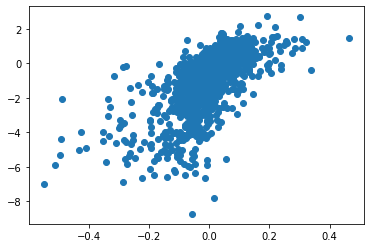

In [4]:
# find covariance
# plot scatter plot
dataset['ret_c'] = dataset['ret_c'].astype(float)
cov = dataset.cov()['stocks ret']['ret_c']
print(cov)
plt.scatter(dataset['stocks ret'], dataset['ret_c'])


In [5]:
dataset['ret_c'].describe()

count    1432.000000
mean       -0.917780
std         1.643979
min        -8.732305
25%        -1.629520
50%        -0.466991
75%         0.165608
max         2.734924
Name: ret_c, dtype: float64

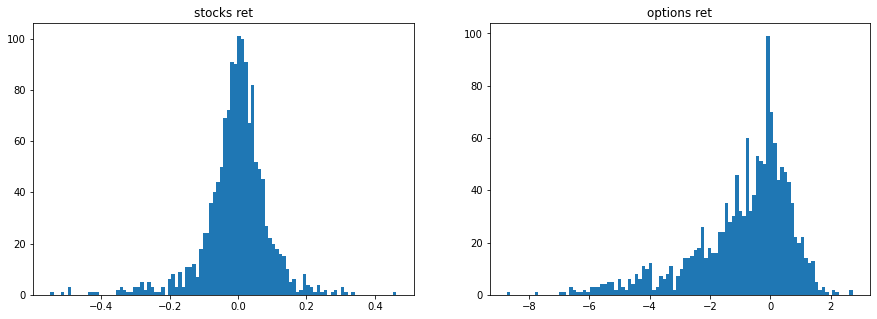

In [6]:
# plot distribution of stocks ret and options ret

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(dataset['stocks ret'], bins=100)
ax[0].set_title('stocks ret')
ax[1].hist(dataset['ret_c'], bins=100)
ax[1].set_title('options ret')
plt.show()


In [7]:
stock_mean = dataset['stocks ret'].mean()
stock_var = dataset['stocks ret'].std() ** 2
option_mean = dataset['ret_c'].mean()
option_var = dataset['ret_c'].std() ** 2
print("stock log return mean: ", stock_mean)
print("stock log return var: ", stock_var)
print("option log return mean: ", option_mean)
print("option log return var: ", option_var)

stock log return mean:  -0.004160599154865518
stock log return var:  0.008844256509524515
option log return mean:  -0.9177798814806845
option log return var:  2.7026667430486944


In [8]:
# valid assumption of stationary stock return, option return and covariance because this is how the market works, even if there is skewed,
# it will revert back, so we can pass look ahead bias check

coef_stock_min = (option_var - cov)/(stock_var + option_var - 2*cov)
coef_option_min = 1 - coef_stock_min
print("stock coef: ", coef_stock_min)
print("option coef: ", coef_option_min)
E_portfolio_min = coef_stock_min * stock_mean + coef_option_min * option_mean
var_portfolio_min = coef_stock_min ** 2 * stock_var + coef_option_min ** 2 * option_var + 2 * coef_stock_min * coef_option_min * cov
print("portfolio log return mean: ", E_portfolio_min)
print("portfolio log return var: ", var_portfolio_min)

stock coef:  1.0366031468476142
option coef:  -0.03660314684761423
portfolio log return mean:  0.029280741598918362
portfolio log return var:  0.005481289465887087


min var portfolio log return mean:  0.029643314285601206
min var portfolio log return var:  0.005481684782821165


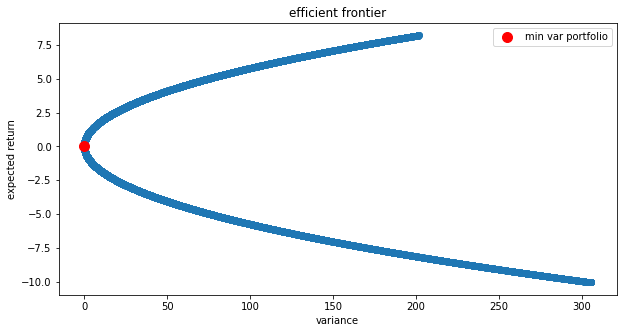

In [9]:
# plot out the efficient frontier

coefs = []
for i in np.arange(-10, 10, 0.001):
    coefs.append([i, 1-i])
coefs = np.array(coefs)


E_portfolio = coefs[:, 0] * stock_mean + coefs[:, 1] * option_mean
var_portfolio = coefs[:, 0] ** 2 * stock_var + coefs[:, 1] ** 2 * option_var + 2 * coefs[:, 0] * coefs[:, 1] * cov

min_var = np.argmin(var_portfolio)
min_var_ret = E_portfolio[min_var]
min_var = var_portfolio[min_var]

print("min var portfolio log return mean: ", min_var_ret)
print("min var portfolio log return var: ", min_var)

plt.figure(figsize=(10, 5))
plt.scatter(var_portfolio, E_portfolio)

# label the min var portfolio
plt.scatter(min_var, min_var_ret, c='r', s=100, label='min var portfolio')
plt.legend()
plt.xlabel('variance')
plt.ylabel('expected return')
plt.title('efficient frontier')
plt.show()


In [10]:
# assume there are 20 trades per year
annualized_log_return_min = 20 * E_portfolio_min
annualized_std_min = var_portfolio_min * 20 ** 0.5
three_month_yield = np.log(1+0.0549)
sharpe_ratio_min = (annualized_log_return_min - three_month_yield) / annualized_std_min
print("sharpe ratio: ", sharpe_ratio_min)


sharpe ratio:  21.70959489623637


In [11]:
# you can use the estimate cost for practice since formula is euivalent

#E[S-C/C] = E[S/C] - 1 = S/E[C] - 1


x = Sale_price = 1.86
option_cost = x * (1 + option_mean)
stock_cost = (option_cost / -coef_option_min) * coef_stock_min
print("option cost: ", option_cost)
print("stock cost: ", stock_cost)

option cost:  0.15292942044592692
stock cost:  4.330969660608905
